<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.DigitRecognizer/blob/main/0_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Stretch tasks:
    - Create a baseline with Batch Normalization, without looking on the Internet
    - Create a baseline with Dropout, without looking on the Internet
    - Implement classic architectures (AlexNet, VGG), without looking
    - Implement model checkpoint callbacks (save every epoch)
    - Write NN with functional API, not looking on the Internet
    - Enwrap your FFNN for grid search CV and find the best architecture
    - Stretch pants approach
    - Correct initialization strategies for different activation functions
    - Use functools.partial in building sequential model
    - Transfer learning

# Imports

In [1]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

## Pep 8 standard

In [2]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

## Custom packages

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager
from sklearn_utils import (
    nan_statistics,
    visualize_datasets_distributions
)

# Setup paths

In [10]:
drive.mount('/content/gdrive', force_remount=True)  # force_remount=True
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 'baseline'
MODELS_TRIAL = 'baseline'
COMPETITION_PATH = gdrive_path + 'ML/Competitions/3.DigitRecognizer/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive


# Download the data

In [82]:
df_train = pd.read_csv(manager.train_path)
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
df_test = pd.read_csv(manager.test_path)
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Quick data exporation

## Nan values

In [28]:
assert not df_train.isna().any().any()
assert not df_test.isna().any().any()

In [32]:
import numpy as np
print(np.max(df_train.values), np.min(df_train.values))
print(np.max(df_test.values), np.min(df_test.values))

255 0
255 0


## Class balance

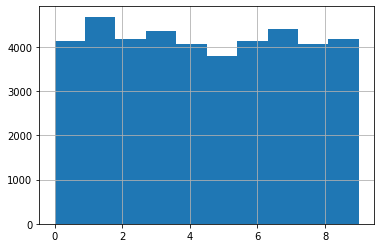

In [37]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
df_train['label'].hist(ax=ax)

# Create train, validation and test sets

In [86]:
from sklearn.model_selection import train_test_split

TRAINVAL_SIZE = 0.8
RANDOM_STATE = 42

df_trainval, df_test_sample = train_test_split(
    df_train,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train['label']
)
df_trainval.shape, df_test.shape

((21504, 785), (28000, 784))

In [87]:
TRAIN_SIZE = 0.8

df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['label']
)
df_train.shape, df_val.shape

((17203, 785), (4301, 785))

# Data exploration (from now on, on train set)

In [44]:
vals = df_train.values[0, 1:]
type(vals)

numpy.ndarray

(-0.5, 27.5, 27.5, -0.5)

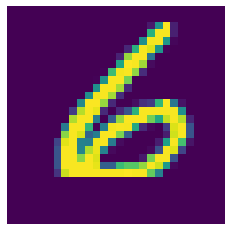

In [46]:
plt.imshow(vals.reshape(28, 28))
plt.axis('off')

# Data preparation

In [88]:
df_test.shape, df_test_sample.shape

((28000, 784), (5376, 785))

In [89]:
df_train.values[:, 1:] = df_train.values[:, 1:] / 255.0
df_val.values[:, 1:] = df_val.values[:, 1:] / 255.0
df_test_sample.values[:, 1:] = df_test_sample.values[:, 1:] / 255.0

df_test.values[:, :] = df_test.values[:, :] / 255.0

In [92]:
assert df_train.values[:, 1:].max() <= 1.0
assert df_test.values.max() <= 1.0
assert df_test_sample.values[:, 1:].max() <= 1.0
assert df_val.values[:, 1:].max()

In [93]:
df_test_sample.values.max()

9

# Save data

In [94]:
manager.save_to_csv(
    df_train,
    manager.data_trial_path,
    'train_processed.csv'
)

manager.save_to_csv(
    df_val,
    manager.data_trial_path,
    'val_processed.csv'
)

In [95]:
manager.save_to_csv(
    df_test_sample,
    manager.data_trial_path,
    'test_sample_processed.csv'
)

In [96]:
manager.save_to_csv(
    df_test,
    manager.data_trial_path,
    'test_processed.csv'
)

# Model preparation

## Sequential baseline

In [122]:
baseline_model = Sequential(
    [
        layers.Input(shape=(784, )),
        layers.Dense(units=784, activation='relu'),
        layers.Dense(units=100, activation='relu'),
        layers.Dense(units=10, activation='softmax')
    ]
)

In [123]:
baseline_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [144]:
X_train = df_train.values[:, 1:]
Y_train = df_train.values[:, 0]

X_validation = df_val.values[:, 1:]
Y_validation = df_val.values[:, 0]

X_test_sample = df_test_sample.values[:, 1:]
Y_test_sample = df_test_sample.values[:, 0]

X_test = df_test.values[:, :]

assert X_train.shape[1] == X_validation.shape[1] == X_test.shape[1]

In [147]:
assert (np.unique(Y_train) == np.unique(Y_validation)).all()
assert (np.unique(Y_validation) == np.unique(Y_test_sample)).all()

In [148]:
history = baseline_model.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    batch_size=32,
    epochs=5
)

Epoch 1/5
538/538 [==============================] - 6s 11ms/step - loss: 1.3114 - accuracy: 0.5136 - val_loss: 1.7903 - val_accuracy: 0.4013
Epoch 2/5
538/538 [==============================] - 5s 9ms/step - loss: 1.3000 - accuracy: 0.5124 - val_loss: 1.8018 - val_accuracy: 0.3964
Epoch 3/5
538/538 [==============================] - 5s 8ms/step - loss: 1.2941 - accuracy: 0.5113 - val_loss: 1.8159 - val_accuracy: 0.3962
Epoch 4/5
538/538 [==============================] - 5s 9ms/step - loss: 1.2870 - accuracy: 0.5154 - val_loss: 1.8308 - val_accuracy: 0.3941
Epoch 5/5
538/538 [==============================] - 5s 8ms/step - loss: 1.2822 - accuracy: 0.5175 - val_loss: 1.8440 - val_accuracy: 0.3980


In [149]:
baseline_model.evaluate(
    X_validation,
    Y_validation
)

135/135 [==============================] - 1s 9ms/step - loss: 1.8440 - accuracy: 0.3980


[1.8440223932266235, 0.39804697036743164]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

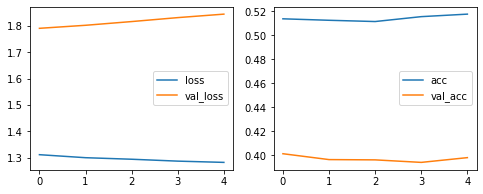

In [153]:
_, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].plot(
    history.history['loss'],
    label='loss'
)
ax[0].plot(
    history.history['val_loss'],
    label='val_loss'
)

ax[0].legend()

ax[1].plot(
    history.history['accuracy'],
    label='acc'
)
ax[1].plot(
    history.history['val_accuracy'],
    label='val_acc'
)
ax[1].legend()

history.history.keys()

## Baseline CNN

In [180]:
X_train.reshape(X_train.shape[0], 28, 28).shape

(17203, 28, 28)

In [190]:
baseline_cnn = Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ]
)

In [191]:
early_stopper = EarlyStopping(
    patience=2,
    monitor='val_loss',
    mode='min'
)

In [192]:
baseline_cnn.compile(
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
    optimizer='adam'
)

In [193]:
history = baseline_cnn.fit(
    X_train.reshape(X_train.shape[0], 28, 28),
    Y_train,
    validation_data=(
        X_validation.reshape(X_validation.shape[0], 28, 28), Y_validation
    ),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopper]
)

Epoch 1/20
538/538 [==============================] - 139s 257ms/step - loss: 1.8171 - accuracy: 0.3576 - val_loss: 1.6499 - val_accuracy: 0.4036
Epoch 2/20
538/538 [==============================] - 144s 269ms/step - loss: 1.6728 - accuracy: 0.4033 - val_loss: 1.6368 - val_accuracy: 0.4129
Epoch 3/20
538/538 [==============================] - 150s 280ms/step - loss: 1.6216 - accuracy: 0.4210 - val_loss: 1.6266 - val_accuracy: 0.4127
Epoch 4/20
538/538 [==============================] - 177s 328ms/step - loss: 1.5871 - accuracy: 0.4271 - val_loss: 1.6272 - val_accuracy: 0.4208
Epoch 5/20
538/538 [==============================] - 145s 269ms/step - loss: 1.5584 - accuracy: 0.4378 - val_loss: 1.6365 - val_accuracy: 0.4225


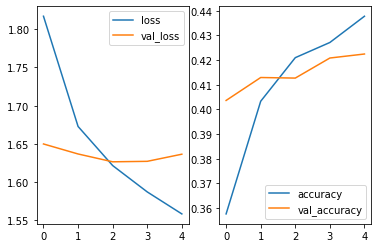

In [197]:
_, ax = plt.subplots(1, 2)
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].legend()

# Enwrap FFNN into grid search CV

In [198]:
X_train[0].shape

(784,)

In [237]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def build_model(
    n_hidden_layers_=3,
    add_dropout_=True,
    width_=100,
    activation_='relu',
    learning_rate_=0.001
):
    model = Sequential()
    model.add(Input(shape=(784,)))

    for _ in range(n_hidden_layers_ - 1):
        model.add(Dense(units=width_, activation=activation_))
    
    if add_dropout_:
        model.add(Dropout(0.4))

    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate_),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    



In [238]:
keras_reg = KerasRegressor(build_model)

<ipython-input-238-e1ebe08fc635>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_model)


In [239]:
from sklearn.model_selection import GridSearchCV

In [240]:
estimator = GridSearchCV(
    keras_reg,
    {
        'n_hidden_layers_': [2, 4],
        'add_dropout_': [True, False],
    },
    cv=3
)

In [241]:
X_train_subsample, _, Y_train_subsample, _ = train_test_split(
    X_train,
    Y_train,
    train_size=0.1,
    random_state=RANDOM_STATE,
    stratify=Y_train
)

X_validation_subsample, _, Y_validation_subsample, _ = \
    train_test_split(
        X_validation,
        Y_validation,
        train_size=0.1,
        random_state=RANDOM_STATE,
        stratify=Y_validation
    )

In [242]:
X_train_subsample.shape, Y_train_subsample.shape, \
    X_validation_subsample.shape, Y_validation_subsample.shape

((1720, 784), (1720,), (430, 784), (430,))

In [243]:
estimator.fit(
    X_train_subsample,
    Y_train_subsample,
    epochs=10,
    validation_data=(X_validation_subsample, Y_validation_subsample),
    batch_size=32,
    callbacks=[EarlyStopping(patience=2, mode='min', monitor='val_accuracy')]
)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 157, in fit
    if (losses.is_categorical_crossentropy(self.model.loss) and
AttributeError: 'NoneType' object has no attribute 'loss'

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/python3.8/dist-packages

AttributeError: ignored

In [260]:
import keras
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[784,]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(10, activation='softmax', **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

In [254]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

<ipython-input-254-651c14c6d32f>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [255]:
res = keras_reg.fit(
    X_train_subsample,
    Y_train_subsample,
    epochs=100,
    validation_data=(X_validation_subsample, Y_validation_subsample),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

# mse_test = keras_reg.score(X_test, y_test)
# y_pred = keras_reg.predict(X_new)

Epoch 1/100
54/54 [==============================] - 1s 6ms/step - loss: 2.3057 - val_loss: 2.3071
Epoch 2/100
54/54 [==============================] - 0s 4ms/step - loss: 2.3050 - val_loss: 2.3066
Epoch 3/100
54/54 [==============================] - 0s 3ms/step - loss: 2.3042 - val_loss: 2.3061
Epoch 4/100
54/54 [==============================] - 0s 3ms/step - loss: 2.3035 - val_loss: 2.3057
Epoch 5/100
54/54 [==============================] - 0s 3ms/step - loss: 2.3028 - val_loss: 2.3053
Epoch 6/100
54/54 [==============================] - 0s 3ms/step - loss: 2.3021 - val_loss: 2.3049
Epoch 7/100
54/54 [==============================] - 0s 3ms/step - loss: 2.3014 - val_loss: 2.3044
Epoch 8/100
54/54 [==============================] - 0s 3ms/step - loss: 2.3007 - val_loss: 2.3040
Epoch 9/100
54/54 [==============================] - 0s 3ms/step - loss: 2.3001 - val_loss: 2.3037
Epoch 10/100
54/54 [==============================] - 0s 4ms/step - loss: 2.2994 - val_loss: 2.3033
Epoch 11/

In [259]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": [0.001, 0.0001]  # reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(
    X_train_subsample,
    Y_train_subsample,
    epochs=10,
    validation_data=(X_validation_subsample, Y_validation_subsample),
    callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
36/36 [==============================] - 2s 18ms/step - loss: 2.3032 - val_loss: 2.3014
Epoch 2/10
36/36 [==============================] - 0s 12ms/step - loss: 2.3031 - val_loss: 2.3013
Epoch 3/10
36/36 [==============================] - 0s 4ms/step - loss: 2.3030 - val_loss: 2.3013
Epoch 4/10
36/36 [==============================] - 0s 3ms/step - loss: 2.3029 - val_loss: 2.3013
Epoch 5/10
36/36 [==============================] - 0s 3ms/step - loss: 2.3028 - val_loss: 2.3013
Epoch 6/10
36/36 [==============================] - 0s 3ms/step - loss: 2.3026 - val_loss: 2.3013
Epoch 7/10
36/36 [==============================] - 0s 3ms/step - loss: 2.3025 - val_loss: 2.3012
Epoch 8/10
36/36 [==============================] - 0s 4ms/step - loss: 2.3024 - val_loss: 2.3012
Epoch 9/10
36/36 [==============================] - 0s 3ms/step - loss: 2.3023 - val_loss: 2.3012
Epoch 10/10
18/18 [==============================] - 0s 2ms/step - loss: 2.3030
Epoch 1/10
36/36 [==================

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f39b7009250>,
                   param_distributions={'learning_rate': [0.001, 0.0001],
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [261]:
rnd_search_cv.best_params_

{'n_neurons': 57, 'n_hidden': 1, 'learning_rate': 0.0001}